In [46]:
# # You only need to run this once per machine
# !pip install -q -U bitsandbytes
# !pip install -q -U git+https://github.com/huggingface/transformers.git
# !pip install -q -U git+https://github.com/huggingface/peft.git
# !pip install -q -U git+https://github.com/huggingface/accelerate.git
# !pip install -q -U datasets scipy ipywidgets
# !pip install wandb

In [47]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

Experimentation on dataset

In [6]:
from datasets import load_dataset
dataset_fr = load_dataset("Babelscape/SREDFM", language="fr")
dataset_fr

DatasetDict({
    train: Dataset({
        features: ['docid', 'title', 'uri', 'text', 'entities', 'relations'],
        num_rows: 870448
    })
    test: Dataset({
        features: ['docid', 'title', 'uri', 'text', 'entities', 'relations'],
        num_rows: 3883
    })
    validation: Dataset({
        features: ['docid', 'title', 'uri', 'text', 'entities', 'relations'],
        num_rows: 2079
    })
})

In [8]:
type(dataset_fr["train"][0])

dict

In [14]:
2079/(2079+3883+870448)

0.002372177405552196

In [15]:
13236/(13236+2701389+6685)

0.004863833962319618

In [12]:
# from create_dataset import load_and_concatenate_datasets
from datasets import load_dataset
dataset_en = load_dataset("Babelscape/SREDFM", language="en")
dataset_en

DatasetDict({
    train: Dataset({
        features: ['docid', 'title', 'uri', 'text', 'entities', 'relations'],
        num_rows: 2701389
    })
    test: Dataset({
        features: ['docid', 'title', 'uri', 'text', 'entities', 'relations'],
        num_rows: 6685
    })
    validation: Dataset({
        features: ['docid', 'title', 'uri', 'text', 'entities', 'relations'],
        num_rows: 13236
    })
})

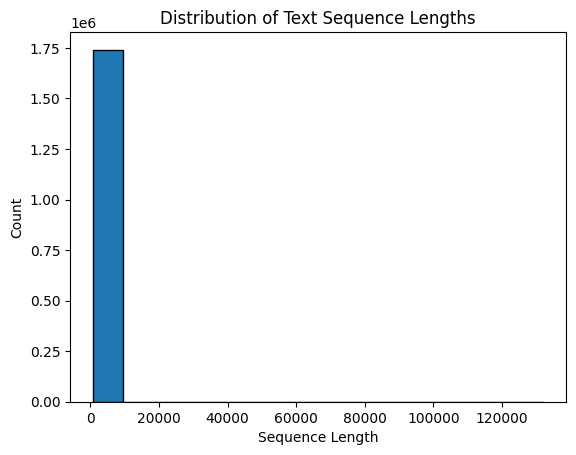

In [8]:
import matplotlib.pyplot as plt

plt.hist(sequence_lengths, ec='black', bins=15)
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.title('Distribution of Text Sequence Lengths')
plt.show()

In [3]:
MAX_LENGTH = 1024

In [1]:
from create_dataset import load_and_concatenate_datasets
dataset_name = "Babelscape/SREDFM"
dataset = load_and_concatenate_datasets(dataset_name)
dataset

Dataset({
    features: ['text'],
    num_rows: 1752820
})

In [3]:
MAX_LENGTH = 1024
new_dataset = dataset.filter(lambda example : len(example["text"])<MAX_LENGTH)
new_dataset

Filter:   0%|          | 0/1752820 [00:00<?, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 498936
})

In [4]:
from create_dataset import redo_train_test_split
split_dataset = redo_train_test_split(new_dataset)
split_dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 493946
    })
    test: Dataset({
        features: ['text'],
        num_rows: 2495
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 2495
    })
})

In [5]:
2495/(2495*2+493946)

0.005000641364824346

In [36]:
498703/1740896

0.28646340734885944

In [37]:
287/7766

0.03695596188514035

In [3]:
from datasets import concatenate_datasets, DatasetDict
concat_dataset = concatenate_datasets([dataset["train"], dataset["test"], dataset["validation"]])
# shuffle the dataset before the new split
shuffled_dataset = concat_dataset.shuffle(seed=80)
train_test_dataset = shuffled_dataset.train_test_split(test_size=0.3, seed=42)

# Split the 30% test + valid in half test, half valid
test_valid = train_test_dataset['test'].train_test_split(test_size=0.5)
# gather everyone if you want to have a single DatasetDict
train_test_valid_dataset = DatasetDict({
    'train': train_test_dataset['train'],
    'test': test_valid['test'],
    'validation': test_valid['train']})
train_test_valid_dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 1226974
    })
    test: Dataset({
        features: ['text'],
        num_rows: 262923
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 262923
    })
})

In [5]:
from datasets import load_dataset
dataset_fr = load_dataset("Babelscape/SREDFM", language="fr")
concat_dataset_fr = concatenate_datasets([dataset_fr["train"], dataset_fr["test"], dataset_fr["validation"]])

dataset_en = load_dataset("Babelscape/SREDFM", language="en")
concat_dataset_en = concatenate_datasets([dataset_en["train"], dataset_en["test"], dataset_en["validation"]])
sliced_dataset_en = (concat_dataset_en
                     .shuffle(seed=42)
                    .select(range(concat_dataset_fr.num_rows)))

In [8]:
concatenate_datasets([concat_dataset_fr, sliced_dataset_en])

Dataset({
    features: ['docid', 'title', 'uri', 'text', 'entities', 'relations'],
    num_rows: 1752820
})

In [1]:
from create_dataset import load_and_concatenate_datasets
dataset = load_and_concatenate_datasets("Babelscape/SREDFM")
dataset

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Dataset({
    features: ['text'],
    num_rows: 1752820
})

In [4]:
filterd_dataset = dataset.filter(lambda example : len(example["text"])<MAX_LENGTH, num_proc=4)

In [11]:
filterd_dataset

Dataset({
    features: ['text'],
    num_rows: 498936
})

In [7]:
from create_dataset import redo_train_test_split
split_dataset = redo_train_test_split(filterd_dataset)
split_dataset_path = './datasets/SREDFM-dataset-'+str(MAX_LENGTH)
split_dataset.save_to_disk(split_dataset_path)

Saving the dataset (0/2 shards):   0%|          | 0/349255 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/74841 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/74840 [00:00<?, ? examples/s]

In [9]:
from datasets import load_from_disk
loaded_dataset = load_from_disk(split_dataset_path)
loaded_dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 349255
    })
    test: Dataset({
        features: ['text'],
        num_rows: 74841
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 74840
    })
})

### 1. Load Dataset

In [48]:
# from datasets import load_dataset
# train_dataset = load_dataset("Babelscape/REDFM", language='fr', split='train')
# eval_dataset = load_dataset("Babelscape/REDFM", language='fr', split='validation')
# test_dataset = load_dataset("Babelscape/REDFM", language='fr', split='test')

In [49]:
from datasets import load_dataset, concatenate_datasets, DatasetDict
dataset_fr = load_dataset("Babelscape/SREDFM", language='fr')
dataset_en = load_dataset("Babelscape/SREDFM", language='en')

In [50]:
dataset_en

DatasetDict({
    train: Dataset({
        features: ['docid', 'title', 'uri', 'text', 'entities', 'relations'],
        num_rows: 2701389
    })
    test: Dataset({
        features: ['docid', 'title', 'uri', 'text', 'entities', 'relations'],
        num_rows: 6685
    })
    validation: Dataset({
        features: ['docid', 'title', 'uri', 'text', 'entities', 'relations'],
        num_rows: 13236
    })
})

In [51]:
dataset_fr

DatasetDict({
    train: Dataset({
        features: ['docid', 'title', 'uri', 'text', 'entities', 'relations'],
        num_rows: 870448
    })
    test: Dataset({
        features: ['docid', 'title', 'uri', 'text', 'entities', 'relations'],
        num_rows: 3883
    })
    validation: Dataset({
        features: ['docid', 'title', 'uri', 'text', 'entities', 'relations'],
        num_rows: 2079
    })
})

In [52]:
assert dataset_en["train"].features.type == dataset_fr["train"].features.type

Slice the english dataset to match the french dataset size

In [53]:
sliced_dataset_en = DatasetDict()
sliced_dataset_en['train'] = dataset_en["train"].shuffle(seed=42).select(range(dataset_fr["train"].num_rows))
sliced_dataset_en['test'] = dataset_en["test"].shuffle(seed=42).select(range(dataset_fr["test"].num_rows))
sliced_dataset_en['validation'] = dataset_en["validation"].shuffle(seed=42).select(range(dataset_fr["validation"].num_rows))

In [54]:
def get_fr_relation(example):
    entities_ls = example["entities"]
    relations = []
    for relation in example['relations']:
        relation_dict = {}
        object_index = relation['object']
        relation_dict["Objet"] = entities_ls[object_index]["surfaceform"]
        relation_dict["Prédicat"] = relation['predicate']
        subject_index = relation['subject']
        relation_dict["Subjet"] = entities_ls[subject_index]["surfaceform"]
        relations.append(relation_dict)

    return str(relations)

In [55]:
def get_en_relation(example):
    entities_ls = example["entities"]
    relations = []
    for relation in example['relations']:
        relation_dict = {}
        object_index = relation['object']
        relation_dict["Object"] = entities_ls[object_index]["surfaceform"]
        relation_dict["Predicate"] = relation['predicate']
        subject_index = relation['subject']
        relation_dict["Subject"] = entities_ls[subject_index]["surfaceform"]
        relations.append(relation_dict)

    return str(relations)

In [56]:
def get_entities(example):
    entities_ls = list(set([entity["surfaceform"] for entity in example["entities"]]))
    return str(entities_ls)

In [57]:
from langchain.prompts import PromptTemplate
def get_fr_prompt_template():
    fr_prompt_template = """
Vous êtes un expert en data science et en traitement du langage naturel(NLP).
Votre tâche consiste à extraire les triplets du TEXTE fourni ci-dessous.
Les entité s'agit du sujet et de l'objet d'une phrase, la liste d'entités doit être sous forme:
['entité1', 'entité2', 'entité3', ...]
Un triplet de connaissances est constitué de 2 entités (sujet et objet) liées par un prédicat : 
{{"Objet": "","Prédicat": "", "Sujet": "" }}
Les triples multiples doivent être sous forme de liste.\n
### TEXTE:
{text}{eos_token}\n
### ENTITES:
{entities}{eos_token}\n
### RELATIONS:
{relations}{eos_token}\n
"""
    return PromptTemplate(template=fr_prompt_template, input_variables=['text', 'eos_token', 'entities', 'relations'])

In [58]:
def get_en_prompt_template():
    en_prompt_template = """You are an expert in data science and natural language processing (NLP).
Your task is to extract triples from the TEXT provided below.
Entities are the subject and object of a sentence, the list of entities must be in the form:
['entity1', 'entity2', 'entity3', ...]
A knowledge triplet is made up of 2 entities (subject and object) linked by a predicate: 
{{"Object": "", "Predicate": "", "Subject": "" }}
Multiple triples must be in list form.\n
### TEXT:
{text}{eos_token}\n
### ENTITIES:
{entities}{eos_token}\n
### RELATIONS:
{relations}{eos_token}\n
"""
    return PromptTemplate(template=en_prompt_template, input_variables=['text', 'eos_token', 'entities', 'relations'])

In [59]:
from transformers import AutoTokenizer
base_model_id = "mistralai/Mistral-7B-v0.1" 
tokenizer = AutoTokenizer.from_pretrained(base_model_id)

tokenizer.pad_token = tokenizer.eos_token

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [60]:
def generate_base_fr_prompt(example):
    template = get_fr_prompt_template()
    full_prompt = template.format(
        text=example["text"],
        eos_token=tokenizer.eos_token,
        entities=get_entities(example),
        relations=get_fr_relation(example)
    )
    return {"text": full_prompt}

In [61]:
def generate_base_en_prompt(example):
    template = get_en_prompt_template()
    full_prompt = template.format(
        text=example["text"],
        eos_token=tokenizer.eos_token,
        entities=get_entities(example),
        relations=get_en_relation(example)
    )
    return {"text": full_prompt}

In [62]:
prompt_dataset_en = sliced_dataset_en.map(generate_base_en_prompt, num_proc=4, remove_columns=['docid', 'title', 'uri', 'entities', 'relations'])
prompt_dataset_en

Map (num_proc=4):   0%|          | 0/870448 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/3883 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/2079 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 870448
    })
    test: Dataset({
        features: ['text'],
        num_rows: 3883
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 2079
    })
})

In [63]:
prompt_dataset_fr = dataset_fr.map(generate_base_fr_prompt, num_proc=4, remove_columns=['docid', 'title', 'uri', 'entities', 'relations'])
prompt_dataset_fr

Map (num_proc=4):   0%|          | 0/870448 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/3883 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/2079 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 870448
    })
    test: Dataset({
        features: ['text'],
        num_rows: 3883
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 2079
    })
})

Concatenate all datasets

In [64]:
concat_dataset_train = concatenate_datasets([prompt_dataset_en["train"], prompt_dataset_fr["train"]])
concat_dataset_test = concatenate_datasets([prompt_dataset_en["test"], prompt_dataset_fr["test"]])
concat_dataset_validation = concatenate_datasets([prompt_dataset_en["validation"], prompt_dataset_fr["validation"]])
dataset_final = DatasetDict({
    "train": concat_dataset_train,
    "test": concat_dataset_test,
    "validation": concat_dataset_validation
}).shuffle(seed=80)
dataset_final

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 1740896
    })
    test: Dataset({
        features: ['text'],
        num_rows: 7766
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 4158
    })
})

In [67]:
dataset_final["train"][10]

{'text': '\nVous êtes un expert en data science et en traitement du langage naturel(NLP).\nVotre tâche consiste à extraire les triplets du TEXTE fourni ci-dessous.\nLes entité s\'agit du sujet et de l\'objet d\'une phrase, la liste d\'entités doit être sous forme:\n[\'entité1\', \'entité2\', \'entité3\', ...]\nUn triplet de connaissances est constitué de 2 entités (sujet et objet) liées par un prédicat : \n{"Objet": "","Prédicat": "", "Sujet": "" }\nLes triples multiples doivent être sous forme de liste.\n\n### TEXTE:\nDernier train pour Washington est le douzième album de la série de bande dessinée "La Jeunesse de Blueberry" de François Corteggiani (scénario), Michel Blanc-Dumont (dessin) et Claudine Blanc-Dumont (couleurs). Publié pour la première fois en 2001, c\'est la troisième du cycle des complots divers (quatre tomes).</s>\n\n### ENTITES:\n[\'Dernier train pour Washington\', \'Claudine Blanc-Dumont\', \'2001\', \'La Jeunesse de Blueberry\', \'Michel Blanc-Dumont\', \'François C

In [73]:
for d in dataset_final["train"].select(range(10)):
    print(d)

{'text': '\nVous êtes un expert en data science et en traitement du langage naturel(NLP).\nVotre tâche consiste à extraire les triplets du TEXTE fourni ci-dessous.\nLes entité s\'agit du sujet et de l\'objet d\'une phrase, la liste d\'entités doit être sous forme:\n[\'entité1\', \'entité2\', \'entité3\', ...]\nUn triplet de connaissances est constitué de 2 entités (sujet et objet) liées par un prédicat : \n{"Objet": "","Prédicat": "", "Sujet": "" }\nLes triples multiples doivent être sous forme de liste.\n\n### TEXTE:\nPiero Weiss (né le à Trieste et mort le à Baltimore) est un pianiste et musicologue italo-américain. </s>\n\n### ENTITES:\n[\'Trieste\', \'Baltimore\', \'Piero Weiss\']</s>\n\n### RELATIONS:\n[{\'Objet\': \'Trieste\', \'Prédicat\': \'place of birth\', \'Subjet\': \'Piero Weiss\'}, {\'Objet\': \'Baltimore\', \'Prédicat\': \'place of death\', \'Subjet\': \'Piero Weiss\'}]</s>\n\n'}
{'text': '\nVous êtes un expert en data science et en traitement du langage naturel(NLP).\nV

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['docid', 'title', 'uri', 'text', 'entities', 'relations'],
        num_rows: 870448
    })
    test: Dataset({
        features: ['docid', 'title', 'uri', 'text', 'entities', 'relations'],
        num_rows: 3883
    })
    validation: Dataset({
        features: ['docid', 'title', 'uri', 'text', 'entities', 'relations'],
        num_rows: 2079
    })
})

In [6]:
dataset["train"][0]["text"]

"Dream Island (en français ) est une île de l'Antarctique située dans l'archipel Palmer, dans le nord de la terre de Graham. Elle se trouve à environ un kilomètre au sud-est du Cap Monaco, au large de la côte sud-ouest de l'île Anvers. \n\nL'île est inspectée en 1956-57 par des scientifiques britanniques du British Naval Hydrographic Survey Unit et nommé par l'UK Antarctic Place-Names Committee.\n\nSituée dans la péninsule Antarctique, une région revendiquée par le Chili, l'Argentine et le Royaume-Uni, elle tombe sous le traité sur l'Antarctique et aucune des revendications n'est actuellement reconnue."

### 2. Load Base Model

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1" 
# base_model_id = "HuggingFaceH4/zephyr-7b-alpha"
# base_model_id = "bofenghuang/vigostral-7b-chat"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

In [ ]:
model

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )

### 3. Tokenization

Set up the tokenizer. Add padding on the left as it [makes training use less memory](https://ai.stackexchange.com/questions/41485/while-fine-tuning-a-decoder-only-llm-like-llama-on-chat-dataset-what-kind-of-pa).


In [ ]:
def tokenize(prompt):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=512,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [24]:
def generate_prompt(example):
    full_prompt =f"""Vous êtes un expert en data science et en traitement du langage naturel(NLP).
Votre tâche consiste à extraire les triplets du TEXTE fourni ci-dessous.
Les entité s'agit du sujet et de l'objet d'une phrase, la liste d'entités doit être sous forme:
['entité1', 'entité2', 'entité3', ...]
Un triplet de connaissances est constitué de 2 entités (sujet et objet) liées par un prédicat : 
{{"Objet": "","Prédicat": "", "Sujet": "" }}
Les triples multiples doivent être sous forme de liste.\n
### TEXTE:
{example["text"]}{tokenizer.eos_token}\n
### ENTITES:
{get_entities(example)}{tokenizer.eos_token}\n
### RELATIONS:
{get_relation(example)}{tokenizer.eos_token}\n
"""
    return {"text": full_prompt}

In [25]:
example = dataset_fr["train"][0]
print(generate_prompt(example)["text"])

Vous êtes un expert en data science et en traitement du langage naturel(NLP).
Votre tâche consiste à extraire les triplets du TEXTE fourni ci-dessous.
Les entité s'agit du sujet et de l'objet d'une phrase, la liste d'entités doit être sous forme:
['entité1', 'entité2', 'entité3', ...]
Un triplet de connaissances est constitué de 2 entités (sujet et objet) liées par un prédicat : 
{"Objet": "","Prédicat": "", "Sujet":"" }
Les triples multiples doivent être séparés par ' | '.

### TEXTE:
Darwinneon crypticus, unique représentant du genre Darwinneon, est une espèce d'araignées aranéomorphes de la famille des Salticidae.</s>

### ENTITES:
['aranéomorphes', 'genre', 'espèce', 'Salticidae', 'famille', 'araignées', 'Darwinneon crypticus']</s>

### RELATIONS:
[{'Objet': 'espèce', 'Prédicat': 'taxon rank', 'Subjet': 'Darwinneon crypticus'}, {'Objet': 'famille', 'Prédicat': 'taxon rank', 'Subjet': 'Salticidae'}]</s>




In [17]:
dataset["train"][0]["entities"]

[{'uri': 'Q33999',
  'surfaceform': 'acteur',
  'type': 'Concept',
  'start': 29,
  'end': 35},
 {'uri': 'Q3282637',
  'surfaceform': 'producteur',
  'type': 'Concept',
  'start': 39,
  'end': 49},
 {'uri': 'Q30',
  'surfaceform': 'américain',
  'type': 'LOC',
  'start': 50,
  'end': 59},
 {'uri': 'Q36091',
  'surfaceform': 'Minneapolis',
  'type': 'LOC',
  'start': 68,
  'end': 79},
 {'uri': 'Q1527',
  'surfaceform': 'Minnesota',
  'type': 'LOC',
  'start': 89,
  'end': 98},
 {'uri': 'Q5398426',
  'surfaceform': 'séries télévisées',
  'type': 'Concept',
  'start': 153,
  'end': 170},
 {'uri': 'Q210257',
  'surfaceform': 'MacGyver',
  'type': 'MEDIA',
  'start': 172,
  'end': 180},
 {'uri': 'Q187462',
  'surfaceform': 'Stargate SG-1',
  'type': 'MEDIA',
  'start': 186,
  'end': 199},
 {'uri': 'Q203047',
  'surfaceform': 'Richard Dean Anderson',
  'type': 'PER',
  'start': 0,
  'end': 21},
 {'uri': '-1^^http://www.w3.org/2001/XMLSchema#decimal',
  'surfaceform': '-1',
  'type': 'NUMBER'

In [14]:
train_dataset = dataset["train"].map(generate_prompt)
val_dataset = dataset["validation"].map(generate_prompt)

Map:   0%|          | 0/870448 [00:00<?, ? examples/s]

TypeError: 'int' object is not subscriptable

### 4. Set Up LoRA
Now, to start our fine-tuning, we have to apply some preprocessing to the model to prepare it for training. For that use the `prepare_model_for_kbit_training` method from PEFT.

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
print_trainable_parameters(model)

trainable params: 262410240 || all params: 3752071168 || trainable%: 6.993743675173274


In [ ]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

# model = get_peft_model(model, config)
# print_trainable_parameters(model)

# # Apply the accelerator. You can comment this out to remove the accelerator.
# model = accelerator.prepare_model(model)

In [ ]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )

In [ ]:
import os, wandb
# os.environ["WANDB_PROJECT"] = "digital_safety"
os.environ["WANDB_BASE_URL"]="https://api.wandb.ai"
wandb.init(project="digital_safety", entity="xianli")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: xianli. Use `wandb login --relogin` to force relogin


In [ ]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [ ]:
import trl

In [19]:
import transformers
from datetime import datetime
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM

project = "KG-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project + "_sft_r_32_alpha_64"
output_dir = "./models/" + run_name
# output_dir = "s3://dec-ds-xli-demologist/" + run_name

tokenizer.pad_token = tokenizer.eos_token


trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    peft_config=config,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=5,
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        gradient_accumulation_steps=2,
        max_steps=2000,
        learning_rate=2.5e-5, # Want about 10x smaller than the Mistral learning rate
        logging_steps=25,
        fp16=True,
        optim="paged_adamw_8bit",
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}",          # Name of the W&B run (optional)
        load_best_model_at_end=True
    ),
    data_collator=DataCollatorForCompletionOnlyLM(tokenizer=tokenizer, response_template="### RELATIONS:"),
    max_seq_length=1024,
    dataset_text_field="text",
    callbacks=[transformers.EarlyStoppingCallback(3)]
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

Map:   0%|          | 0/416 [00:00<?, ? examples/s]

/home/ubuntu/miniconda3/envs/finetune_venv/lib/python3.11/site-packages/trl/trainer/sft_trainer.py:214: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/ubuntu/miniconda3/envs/finetune_venv/lib/python3.11/site-packages/trl/trainer/utils.py:120: UserWarning: Could not find response key `### RELATIONS:` in the following instance: <s> Vous êtes un expert en data science et en traitement du langage naturel(NLP).
Votre tâche consiste à extraire les triplets du TEXTE fourni ci-dessous.
Un triplet de connaissances est co

Step,Training Loss,Validation Loss


/home/ubuntu/miniconda3/envs/finetune_venv/lib/python3.11/site-packages/trl/trainer/utils.py:120: UserWarning: Could not find response key `### RELATIONS:` in the following instance: <s> Vous êtes un expert en data science et en traitement du langage naturel(NLP).
Votre tâche consiste à extraire les triplets du TEXTE fourni ci-dessous.
Un triplet de connaissances est constitué de 2 entités (sujet et objet) liées par un prédicat : 
['sujet', 'prédicat', 'objet'].
Les triples multiples doivent être séparés par ' | '.

### TEXTE:
Ce roman décrit un monde alternatif dans lequel l'Allemagne nazie, l'Empire du Japon et l'Italie fasciste ont remporté la Seconde Guerre mondiale et fait l'état des lieux quinze ans après cette victoire. </s> 

### RELATIONS:
[’Seconde Guerre mondiale’, ’participant’, ’Allemagne nazie’]</s> 

 This instance will be ignored in loss calculation. Note, if this happens often, consider increasing the `max_seq_length`.
  warnings.warn(
/home/ubuntu/miniconda3/envs/fine

OutOfMemoryError: CUDA out of memory. Tried to allocate 224.00 MiB. GPU 0 has a total capacty of 22.19 GiB of which 49.50 MiB is free. Including non-PyTorch memory, this process has 22.10 GiB memory in use. Of the allocated memory 21.36 GiB is allocated by PyTorch, and 443.23 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
trainer.save_model('./models')

### 6. Drum Roll... Try the Trained Model!

By default, the PEFT library will only save the QLoRA adapters, so we need to first load the base Mistral model from the Huggingface Hub:

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# base_model_id = "bofenghuang/vigostral-7b-chat"
base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
    # use_auth_token=True
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "../fine-tuning/models/mistral-KG-finetune/checkpoint-150")

In [14]:
ft_model.save_pretrained("/home/ubuntu/fine-tuning/models/merged_model")

In [12]:
example = test_dataset[1]
print("Texte: " + example['text'])
print("Relations: " + get_relation(example) + "\n")

eval_prompt = f"""Vous êtes un expert en data science et en traitement du langage naturel(NLP). Votre tâche consiste à extraire les triplets du TEXTE fourni ci-dessous. Un triplet de connaissances est constitué de 2 entités (sujet et objet) liées par un prédicat : ['sujet', 'prédicat', 'objet']. Les triples multiples doivent être séparés par ' | '.\n

### Texte :
{example['text']}

### Relations :
"""
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, pad_token_id=2)[0], skip_special_tokens=True))

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Texte: Chang'e 4 (du , de "Chang'e", déesse de la Lune dans la mythologie chinoise) est une sonde spatiale lunaire chinoise dont le lancement a eu lieu le . L'engin est une réplique de la sonde lunaire Chang'e 3, lancée en 2013. C'est le engin spatial chinois lancé vers la Lune et le deuxième à s'y poser. Chang'e 4 comprend un atterrisseur et un rover. Les deux engins spatiaux emportent plusieurs instruments dont des caméras, un spectromètre infrarouge pour mesurer la composition du sol à proximité du rover et un radar détectant la structure superficielle du sous-sol ainsi qu'un spectromètre radio pour analyser les éruptions solaires. La mission primaire doit durer 90 jours. 
Relations: [’Chang'e 4’, ’nommé d'après’, ’Chang'e’] | [’Chang'e 4’, ’instance de’, ’sonde spatiale’] | [’Chang'e 4’, ’suit’, ’Chang'e 3’]

Vous êtes un expert en data science et en traitement du langage naturel(NLP). Votre tâche consiste à extraire les triplets du TEXTE fourni ci-dessous. Un triplet de connaissan

In [11]:
# example = test_dataset[1]
print("Texte: " + example['text'])
print("Relations: " + get_relation(example) + "\n")

Texte: Chang'e 4 (du , de "Chang'e", déesse de la Lune dans la mythologie chinoise) est une sonde spatiale lunaire chinoise dont le lancement a eu lieu le . L'engin est une réplique de la sonde lunaire Chang'e 3, lancée en 2013. C'est le engin spatial chinois lancé vers la Lune et le deuxième à s'y poser. Chang'e 4 comprend un atterrisseur et un rover. Les deux engins spatiaux emportent plusieurs instruments dont des caméras, un spectromètre infrarouge pour mesurer la composition du sol à proximité du rover et un radar détectant la structure superficielle du sous-sol ainsi qu'un spectromètre radio pour analyser les éruptions solaires. La mission primaire doit durer 90 jours. 
Relations: [’Chang'e 4’, ’nommé d'après’, ’Chang'e’] | [’Chang'e 4’, ’instance de’, ’sonde spatiale’] | [’Chang'e 4’, ’suit’, ’Chang'e 3’]

